In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device : {device}")

Using Device : cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.70MB/s]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

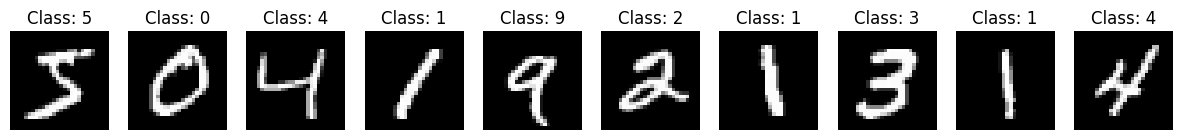

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i in range(10):
  image, label = train_dataset[i]
  axes[i].imshow(image.squeeze(), cmap='gray')
  axes[i].set_title(f"Class: {label}")
  axes[i].axis("off")
plt.show()

In [ ]:
class CNN_example(nn.Module):
  def __init__(self):
    super(CNN_example, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) #added one more CNN layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(128 * 3 * 3, 128)
    self.fc2 = nn.Linear(128, 32) #added two more fully connected layer
    self.fc3 = nn.Linear(32, 10)
    self.dropout = nn.Dropout(0.2) #utilised dropout function
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))
    x = self.pool(x)
    x = x.view(-1, 128 * 3 * 3)
    x = self.dropout(self.relu(self.fc1(x)))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x



In [ ]:
model = CNN_example()
model

CNN_example(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [ ]:
start_time = time.time()
model=CNN_example().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
num_epochs=5
for epoch in range(num_epochs):
    model.train()
    running_loss=0
    for i,(images,labels) in enumerate(train_loader):
        images,labels=images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if(i+1)%100==0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0
end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken: {execution_time:.4f} seconds")

Epoch [1/5], Step [100/938], Loss: 1.0233
Epoch [1/5], Step [200/938], Loss: 0.2180
Epoch [1/5], Step [300/938], Loss: 0.1528
Epoch [1/5], Step [400/938], Loss: 0.1258
Epoch [1/5], Step [500/938], Loss: 0.1136
Epoch [1/5], Step [600/938], Loss: 0.1087
Epoch [1/5], Step [700/938], Loss: 0.0785
Epoch [1/5], Step [800/938], Loss: 0.0886
Epoch [1/5], Step [900/938], Loss: 0.0779
Epoch [2/5], Step [100/938], Loss: 0.0631
Epoch [2/5], Step [200/938], Loss: 0.0547
Epoch [2/5], Step [300/938], Loss: 0.0574
Epoch [2/5], Step [400/938], Loss: 0.0619
Epoch [2/5], Step [500/938], Loss: 0.0501
Epoch [2/5], Step [600/938], Loss: 0.0600
Epoch [2/5], Step [700/938], Loss: 0.0593
Epoch [2/5], Step [800/938], Loss: 0.0536
Epoch [2/5], Step [900/938], Loss: 0.0473
Epoch [3/5], Step [100/938], Loss: 0.0409
Epoch [3/5], Step [200/938], Loss: 0.0465
Epoch [3/5], Step [300/938], Loss: 0.0402
Epoch [3/5], Step [400/938], Loss: 0.0428
Epoch [3/5], Step [500/938], Loss: 0.0411
Epoch [3/5], Step [600/938], Loss:

In [ ]:
model.eval() #dropout
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1) # (Batch_size,10) [0.5 -10 12] 2
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
    print(f"Accuracy on the test set: {100 * correct / total:.2f}%")

Accuracy on the test set: 99.15%


In [ ]:
torch.save(model.state_dict(), 'simple_cnn.pth')
print("Model saved as ' simple_cnn.pth' ")

Model saved as ' simple_cnn.pth' 
